<a href="https://colab.research.google.com/github/1Anvitha/PRA3024_25/blob/main/GW_tutorial_2_detector_noise_PSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GW tutorial 2: Detector noise and GW150914

Author: Melissa Lopez

Email: m.lopez@uu.nl

Note that we are importing some packages to be able to read the data.

In [67]:
%matplotlib inline
!pip install pycbc
!pip install gwpy
!pip install numpy
from pycbc.catalog import Merger
from gwpy.timeseries import TimeSeries
import pycbc.psd
import pylab
import matplotlib.pyplot as plt
import numpy as np

In the previous part we have seen the detector response to gravitational waves (GW). Currently, we have three ground-based detectors: LIGO Hanford (H1), LIGO Livingston (L1) and Virgo (V1). But what does the data actually look like?

To answer this question we are going to take a look at the first detection: **GW150914**. Let's load the data from L1

In [68]:
detected_id = 'GW150914'
m = Merger(detected_id)
ifo = 'L1'
data = m.strain(ifo)

**some of the code is mine from last year , there were errors which I fixed using Blackbox ai , but there were also some code I wrote using the help of my friend studying computer science since coding does not come naturally to me and I did not know how to reference this, hence the text.There are some parts of the code which i completely wrote by myself but I needed some help majoritively all along **


**Exercise 1:** We can see that this object is a PyCBC timeseries, and as such you can check what their atributes are (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#module-pycbc.types.timeseries)). Let's check some of them.

- How much is the duration of the time series?

- How much is its sampling rate?

- How many data points does it have?

- How much is $\Delta_{f}$ and $\Delta_{t}$? Can you find a relation between these and the number of data points?

_Hint:_ $\Delta_{f} = 1/duration$ and  $\Delta_{t} = 1/sample\_rate$

In [69]:
print(f"Detection: {detected_id}\n")


duration = data.duration  # Total duration of the time series in seconds
sampling_rate = data.sample_rate  # Sampling rate in Hz (samples per second)

delta_f = 1. / duration  # Frequency resolution (spacing between frequency bins in Hz)
time_resolution = 1. / sampling_rate  # Time resolution (spacing between time samples in seconds)

print(f"Duration of time series: {duration} s")
print(f"Sampling Rate: {sampling_rate} Hz")
print(f"Data points: {data.shape[0]}")
print(f"frequency resolution: {delta_f} Hz")
print(f"time resolution: {time_resolution} s")

Detection: GW150914

Duration of time series: 32.0 s
Sampling Rate: 4096.0 Hz
Data points: 131072
frequency resolution: 0.03125 Hz
time resolution: 0.000244140625 s


The previous magnitudes are key parameters of the timeseries. Now, let's plot the actual data to see what it looks like.

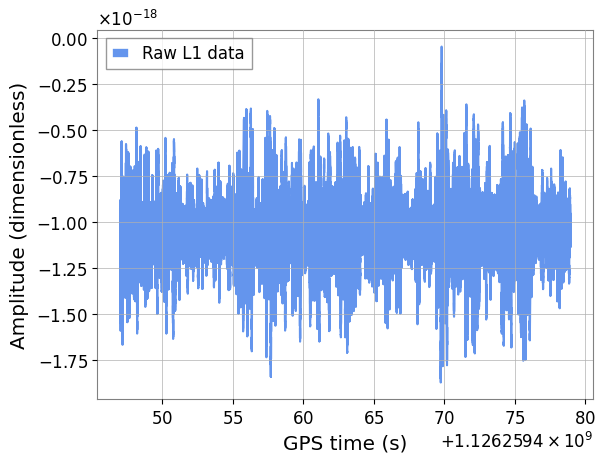

In [70]:
plt.plot(data.sample_times, data, label='Raw L1 data', color='cornflowerblue')
plt.xlabel('GPS time (s)')
plt.ylabel('Amplitude (dimensionless)')
plt.legend()

In GW we use the GPS time to determine at what time the GW signals reached Earth. You can see that the amplitude of this data is super small, $\mathcal{O}(10^{-18})$! GW interferometers are able to detect a change in distance of ~1/10,000th the size of a proton.

But, where is GW190514? We cannot see it (yet) as there are many different contributions from the detector. The detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design.

**Exercise 2**: Estimate the PSD of the data using `filter_psd` (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.filter_psd)) and plot it. Limit your plot according to the minimum frequency (say, 1 Hz) and  the Nyquist frequency.

_Hint_: Note that the PSD is a frequency series.

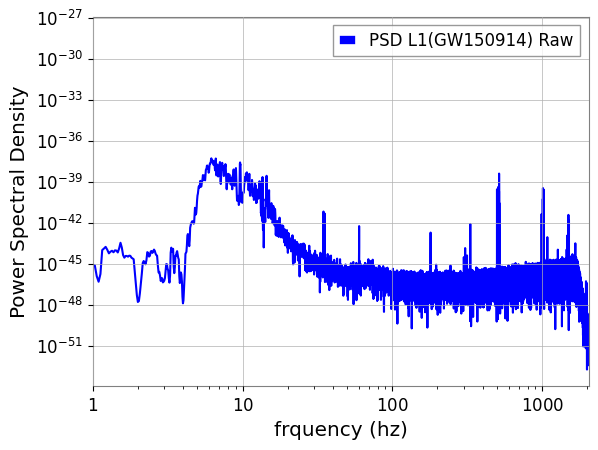

In [71]:
flow = 1 #(low frequency cutoff)
psd = data.filter_psd(duration, delta_f , flow)

plt.loglog(psd.get_sample_frequencies() , psd , label=f"PSD L1({detected_id}) Raw" , color='blue')

plt.xlim(1 , sampling_rate/2)

plt.xlabel("frquency (hz)")
plt.ylabel (r'Power Spectral Density')
plt.legend()

there is a high noise at lower frequencies, i think it is because of the seismic noise.

the graph shows a region where LIGO is very sensitive to gravitational waves near 10Hz and 100HZ , this might be because shot noises dominate only at higher frequencies and thermal nise is minimizes in this band.

the code above will not work if the filter_psd crashes. to stop the code form crashig I initially added


 "psd = data.filter_psd(duration, frequency_resolution, flow)
except Exception as e:"

    #print(f"Error computing PSD: {e}")
    psd = None



but it did not work so I took it off


In [72]:
# #this was the code i wrote before , my first attempt


# #Given parameters
# fs = 4096  # Sampling frequency in Hz
# duration = 32
# N = int(fs * duration)
# #Generate synthetic data
# t = np.linspace(0, duration, N, endpoint=False)
# data = np.sin(2*np.pi*50*t) + 0.5*np.random.randn(N)  #Example
# # Compute FFT
# fft_values = np.fft.fft(data)
# frequencies = np.fft.fftfreq(N, d=1/fs)
# # Compute PSD
# psd = (np.abs(fft_values) ** 2) / N
# #Keep only positive frequencies
# positive_freqs = frequencies[:N//2]
# positive_psd = psd[:N//2]
# # Apply frequency limits
# nyquist_freq = fs / 2
# mask = (positive_freqs >= 1) & (positive_freqs <= nyquist_freq)
# filtered_frequencies = positive_freqs[mask]
# filtered_psd = positive_psd[mask]
# # Plot the PSD
# plt.figure(figsize=(10, 6))
# plt.loglog(filtered_frequencies, filtered_psd)
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Power Spectral Density')
# plt.title('Power Spectral Density (PSD) using FFT')
# plt.grid()
# plt.show()

The PSD shows us what are the different contributions of the detector noise.
While we computed the PSD from 1 Hz, you can see that there is a weird behaviour for frequencies < 5 Hz. This is because the detector is not calibrated at these frequencies, so our analysis needs to start at higher frequencies. For current ground based detectors, we usually start at 10 Hz or higher, depending on the source.

GW signals are tiny, so with this much noise we won't be able to see GW150914. To "flatten" all frequency contributions we whiten the data.

**Exercise 3:** We can whiten the data with [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.whiten) function. Use `segment_duration = 4` and `max_filter_duration=4`.

- Plot the whitened data next to the raw detector noise. What differences can you see?

- Estimate the PSD of the whitened data. Plot it in the same graph as the raw PSD. What differences can you see?


#**this was the code i had written earlier**
#Given parameters
fs = 4096  # Sampling frequency in hertz
duration = 32  # Duration of the signal
N = int(fs * duration)  # Number of data points
# Simulated raw data in place of the actual dataset
t = np.linspace(0, duration, N, endpoint=False)
raw_data = np.sin(2 * np.pi * 50 * t) + 0.5 * np.random.randn(N)  # Example signal with noise
#Compute FFT of raw data
fft_values = np.fft.fft(raw_data)
frequencies = np.fft.fftfreq(N, d=1/fs)
# Compute power spectral density
psd_raw = (np.abs(fft_values) ** 2) / N
# Whitening process: Divide by square root of PSD to normalize
epsilon = 1e-10  #Small constant to prevent division by zero
whitened_fft_values = fft_values / (np.sqrt(psd_raw) + epsilon)
# Convert back to time domain using inverse FFT
whitened_data = np.fft.ifft(whitened_fft_values).real# Taking only the real part
# Compute PSD of whitened data
fft_values_whitened = np.fft.fft(whitened_data)
psd_whitened = (np.abs(fft_values_whitened)**2)/N
# Keep only positive frequencies
positive_freqs = frequencies[:N//2]
positive_psd_raw = psd_raw[:N//2]
positive_psd_whitened = psd_whitened[:N//2]
# Plot raw and whitened data in time domain
plt.figure(figsize=(12, 5))
plt.plot(t[:1000], raw_data[:1000], label="Raw Data", alpha=0.7)
plt.plot(t[:1000], whitened_data[:1000], label="Whitened Data", alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Raw vs. Whitened Data in Time Domain")
plt.legend()
plt.grid()
plt.show()
# Plot PSD comparison
plt.figure(figsize=(10, 6))
plt.loglog(positive_freqs, positive_psd_raw, label="Raw PSD", alpha=0.7)
plt.loglog(positive_freqs, positive_psd_whitened, label="Whitened PSD", alpha=0.7)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.title("Power Spectral Density: Raw vs. Whitened Data")
plt.legend()
plt.grid()
plt.show()

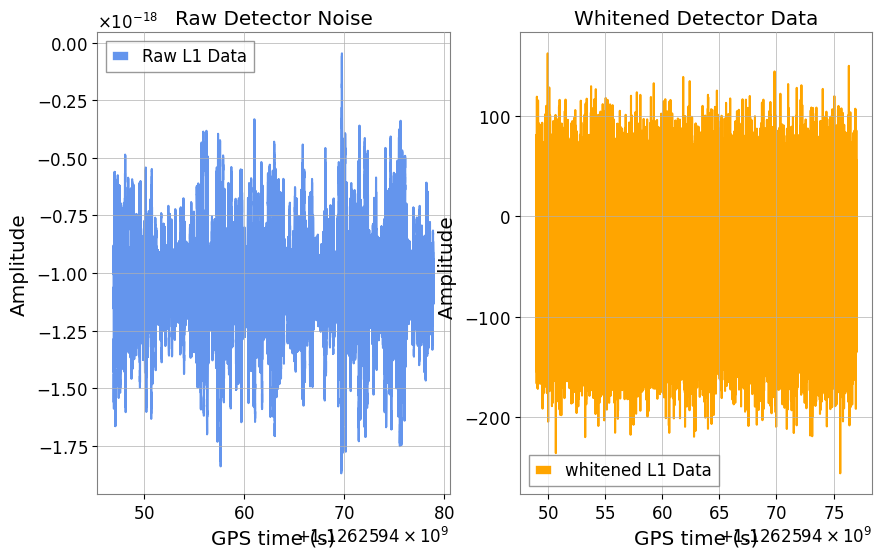

Text(0.5, 1.0, 'Comparison ')

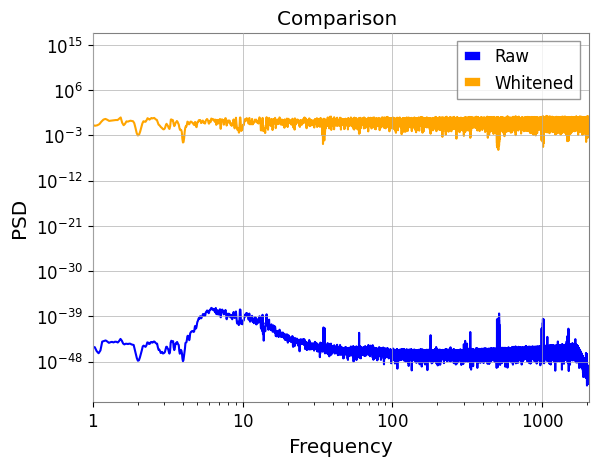

In [73]:
#whitening the data
segment_duration = 4
max_filter_duration = 4
#function taken from pycbc
whitened_data = data.whiten(segment_duration , max_filter_duration)

#plotting the function raww
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plt.plot(data.sample_times, data, label="Raw L1 Data", color="cornflowerblue")
plt.xlabel("GPS time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.title('Raw Detector Noise')
#to plot the whitened psd
plt.subplot(1,2,2)
plt.plot(whitened_data.sample_times , whitened_data, label = 'whitened L1 Data' , color = 'orange')
plt.xlabel("GPS time (s)")
plt.ylabel("Amplitude ")
plt.legend()
plt.title("Whitened Detector Data")


plt.show()

#to plot the comparison of the raw and the whitened

whitened_psd = whitened_data.filter_psd(whitened_data.duration, whitened_data.delta_f, flow=1)

plt.loglog(psd.get_sample_frequencies(), psd, label="Raw", color='blue')
plt.loglog(whitened_psd.get_sample_frequencies (), whitened_psd, label="Whitened", color= "orange")

plt.xlim(flow, data.sample_rate/2) #flow = 1
plt.xlabel("Frequency")
plt.ylabel(r"PSD")
plt.legend ()
plt.title("Comparison ")

the raw data shows variations in amplitude within a narrow range. the waveform appears correlated over time, showing there is a very low frequency component like a background noise.


whereas the whitened data shows change int he amplitude distribution with range getting bigger, explicitly showing us that the background noise or whatever it was at lower frequency has been filtered out or supressed. and the signal remaining is distributed more uniformly.

,Now all frequency contributions are at the same level, as we can see from the PSD. However, GW150914 is still hidden in the data.


**Exercise 4:** We can apply a [low pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.lowpass_fir) and a [high pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.highpass_fir) to limit the frequency of the data. The low pass filters above 250 Hz (order=512) and the high pass filters below 30 Hz (order=512).

- Estimate the PSD of the bandpassed data and plot it together with the raw PSD and the whitened PSD. What is the bandpass doing?

- Plot the bandpassed data [cropping](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.crop) 12s on the left and 13s on the right. What can you see? Compare this to the raw data. What frequencies dominate in each case?

In [74]:



# low_cutoff = 30
# high_cutoff = 250

# time = np.linspace(0,duration , N, endpoint=False)
# signal1 = np.sin(2*np.pi*50*time)
# signal2 = np.sin(2*np.pi*100*time)
# data = signal1 + signal2

# def bandpass_filter(signal , fs , low_cut , high_cut):
#   N = len(signal)
#   freqs = np.fft.fftfreq(N, d=1/fs)
#   fft_values = np.fft.fft(signal)

#   bandpass_mask = (np.abs(freqs) >= low_cut) & (np.abs(freqs) <= high_cut)

#   fft_filtered = np.zeros_like(fft_values, dtype=complex)
#   fft_filtered[bandpass_mask] = fft_values[bandpass_mask]

#   return np.fft.ifft(fft_filtered).real
# filtered_data = bandpass_filter(data, fs, low_cutoff, high_cutoff)
# def calculate_psd(signal, fs):
#     N = len(signal)
#     freqs = np.fft.fftfreq(N, d=1/fs)
#     fft_values = np.fft.fft(signal)
#     psd = np.abs(fft_values) ** 2 / N  #spectral density
#     return freqs[:N//2], psd[:N//2]  #only positive frequencies
# #PSDs for raw and filtered signals
# freqs, psd_raw = calculate_psd(data, fs)
# _, psd_filtered = calculate_psd(filtered_data, fs)
# # Plot PSDs
# plt.figure(figsize=(10, 5))
# plt.semilogy(freqs, psd_raw, label='Raw PSD', alpha=0.7)
# plt.semilogy(freqs, psd_filtered, label='Bandpassed PSD', linestyle='dashed')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Power Spectral Density')
# plt.title('Comparison of Raw and Bandpassed PSD')
# plt.legend()
# plt.grid()
# plt.show()
# #for 12s (left) and 13s (right)
# left_crop = filtered_data[:int(12 * fs)]
# right_crop = filtered_data[-int(13 * fs):]

# plt.figure(figsize=(10, 5))
# plt.plot(np.linspace(0, 12, len(left_crop)), left_crop, label='First 12s')
# plt.plot(np.linspace(0, 13, len(right_crop)), right_crop, label='Last 13s', alpha=0.7)
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.title('Bandpassed Data Cropping (12s left, 13s right)')
# plt.legend()
# plt.grid()
# plt.show()


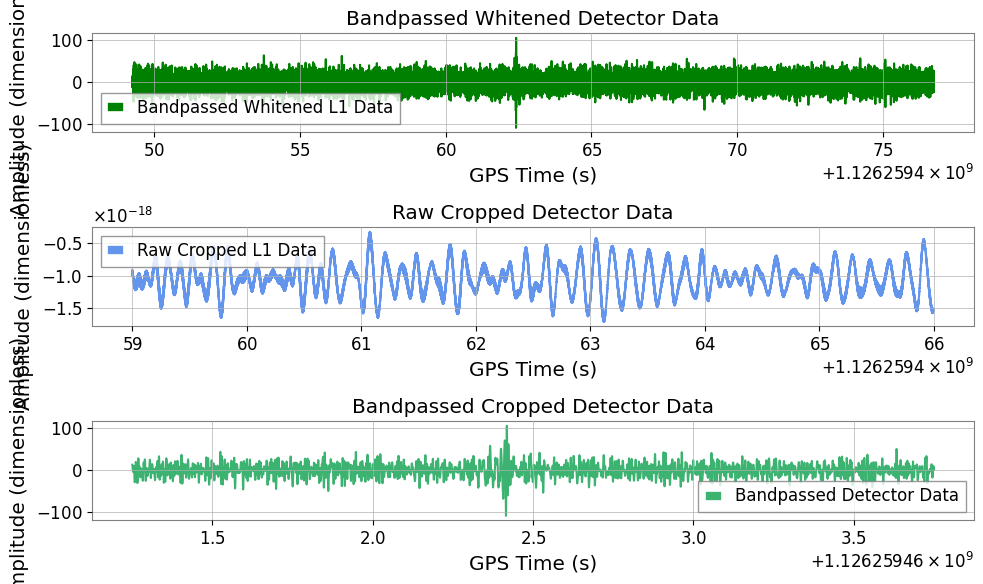

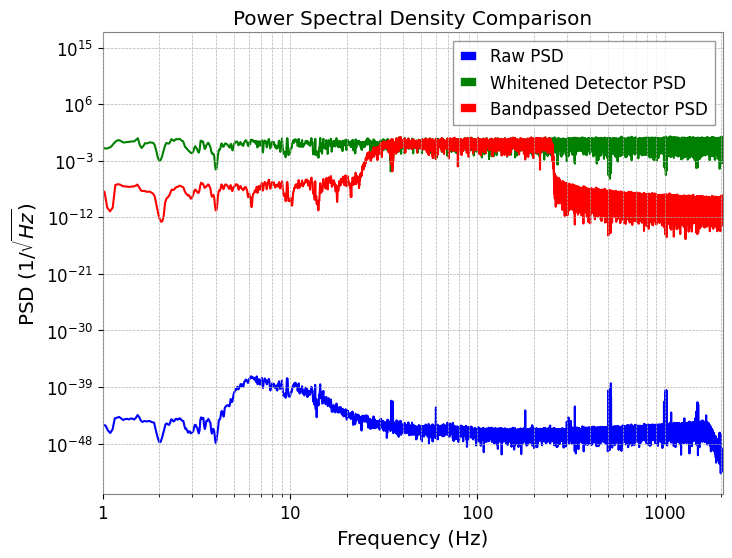

In [75]:
# Function to apply bandpass filtering
def bandpass_data(data_input, low_cutoff=30, high_cutoff=250, order=512): #keeps the range where GW are most detectable

    return data_input.highpass_fir(low_cutoff, order).lowpass_fir(high_cutoff, order) #removed low freq seismmic noise and high freq instrumental noise

# bandpass filtering
bandpassed_data = bandpass_data(whitened_data)

# Compute PSD of bandpassed data
bandpassed_psd = bandpassed_data.filter_psd(bandpassed_data.duration, bandpassed_data.delta_f, flow=1)
#the above step characterises the nnoise in different freq bands, to help identify the unwanted noise and to filter it out for  etter results

# Crop Data
bpsd_crop = bandpassed_data.crop(12, 13)
data_crop = data.crop(12, 13)


ffig, axes = plt.subplots(3, 1, figsize=(10, 6))  # 3 rows, 1 column
#whitened plot
axes[0].plot(bandpassed_data.sample_times, bandpassed_data, label='Bandpassed Whitened L1 Data', color='green')
axes[0].set_xlabel('GPS Time (s)')
axes[0].set_ylabel("Amplitude (dimensionless)")
axes[0].set_title("Bandpassed Whitened Detector Data")
axes[0].legend()

#raw data plot
axes[1].plot(data_crop.sample_times, data_crop, label='Raw Cropped L1 Data', color='cornflowerblue')
axes[1].set_xlabel('GPS Time (s)')
axes[1].set_ylabel("Amplitude (dimensionless)")
axes[1].set_title("Raw Cropped Detector Data")
axes[1].legend()

#cropped data graph
axes[2].plot(bpsd_crop.sample_times, bpsd_crop, label='Bandpassed Detector Data', color='mediumseagreen')
axes[2].set_xlabel('GPS Time (s)')
axes[2].set_ylabel("Amplitude (dimensionless)")
axes[2].set_title("Bandpassed Cropped Detector Data")
axes[2].legend()


plt.tight_layout()

#compariosn plotting
plt.figure(figsize=(8, 6))
plt.loglog(psd.get_sample_frequencies(), psd, label='Raw PSD', color='blue')
plt.loglog(whitened_psd.get_sample_frequencies(), whitened_psd, label='Whitened Detector PSD', color='green')
plt.loglog(bandpassed_psd.get_sample_frequencies(), bandpassed_psd, label='Bandpassed Detector PSD', color='red')

plt.xlim(flow, data.sample_rate / 2)
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'PSD $(1/\sqrt {Hz})$')
plt.legend()
plt.title("Power Spectral Density Comparison")
plt.grid(which="both", linestyle="--", linewidth=0.5)

plt.show()

the first plot shows the bandpassed filtered data and whitened data over longer range , with reduced frequency noise it looks centered around zero compared to raw data.

at 65 sec it suggests a possible short lived evnt, could be a GW signal.


the raw detector data focuses on the suspected signal . unlike the above graph this one shows a string oscillation with visible frequency evolution, resembling a chirp signal. and these noises are indicative of gravitational wave candidate.


the third graph displays the same time segment after whitening and bandpass filtering.
the signal is now more defined with high frequency noise suppressed.

the feature at 2.5 secs is more prominent, aligning with the expected result of the compact binary coal.



**Exercise 5:** Last but not least, we generate a spectrogram (time-frequency representation) using [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.qtransform) function.

_Hint_: logfsteps=200, qrange=(110, 110), frange=(20, 512), vmax=3.5 as it is standard

In [76]:
# def compute_spectrogram(signal, fs, window_size=4096, overlap=2048):
#     step = window_size - overlap
#     n_windows = (len(signal) - window_size) // step
#     spectrogram = []
#     time_axis = []

#     for i in range(n_windows):
#         start = i * step
#         windowed_signal = signal[start:start + window_size] * np.hanning(window_size)
#         fft_vals = np.abs(np.fft.fft(windowed_signal)[:window_size//2])
#         spectrogram.append(fft_vals)
#         time_axis.append(start / fs)

#     spectrogram = np.array(spectrogram).T
#     freq_axis = np.linspace(0, fs/2, window_size//2)
#     return time_axis, freq_axis, spectrogram
# #spectrogram
# t_spec, f_spec, Sxx = compute_spectrogram(filtered_data, fs)
# plt.figure(figsize=(10, 5))
# plt.pcolormesh(t_spec, f_spec, 10 * np.log10(Sxx), shading='auto', vmax=3.5)
# plt.ylabel('Frequency (Hz)')
# plt.xlabel('Time (s)')
# plt.title('Spectrogram of Bandpassed Data')
# plt.colorbar(label='Power (dB)')
# plt.show()

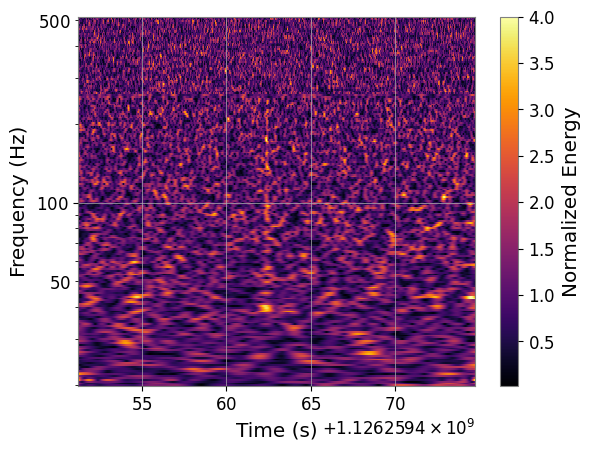

In [77]:
#Perform a Q-transform on the bandpassed data
times, freqs, power = bandpassed_data.qtransform(0.01, logfsteps=200, qrange=(110, 110), frange=(20, 512))
#the 0.01 defines the time resolution of the transform
#200 sets the number of frequency bins logarithmically spaced
#(110,110) defines the quality factor of the transform.
c = 200
#generates a heatmap
plt.pcolormesh(times[c: -c], freqs, power[:, c:-c]**0.5, vmax=4, cmap="inferno")

plt.yscale('log')
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.colorbar(label="Normalized Energy")
plt.show()


the colour intensity represents the energy of the signal at different tiem freq noise.

As we have seen, the detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design. Let's see how the detectors will improve in the next observing runs.

**Bonus track:** From the `sensitivity_curves` folder [load](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.read.from_txt) the PSD s:

- Third observing run of H1: `aligo_O3actual_H1.txt`
- Third observing run of L1: `aligo_O3actual_L1.txt`
- Third observing run of V1: `avirgo_O3actual.txt`
- Simulated fourth observing run of LIGO: `aligo_O4high.txt`

Note that these PSDs are from [LIGO public website](https://dcc.ligo.org/ligo-t2000012/public). Also read the PSD of [Einstein Telescope](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.EinsteinTelescopeP1600143) (ET) and [Cosmic Explorer](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.CosmicExplorerP1600143) (CE)

Plot all these PSDs. What can you say about ET and CE improvements?

_Hint_: Minimum frequency is 10 Hz, sampling rate 8192 Hz and duration is 16s.


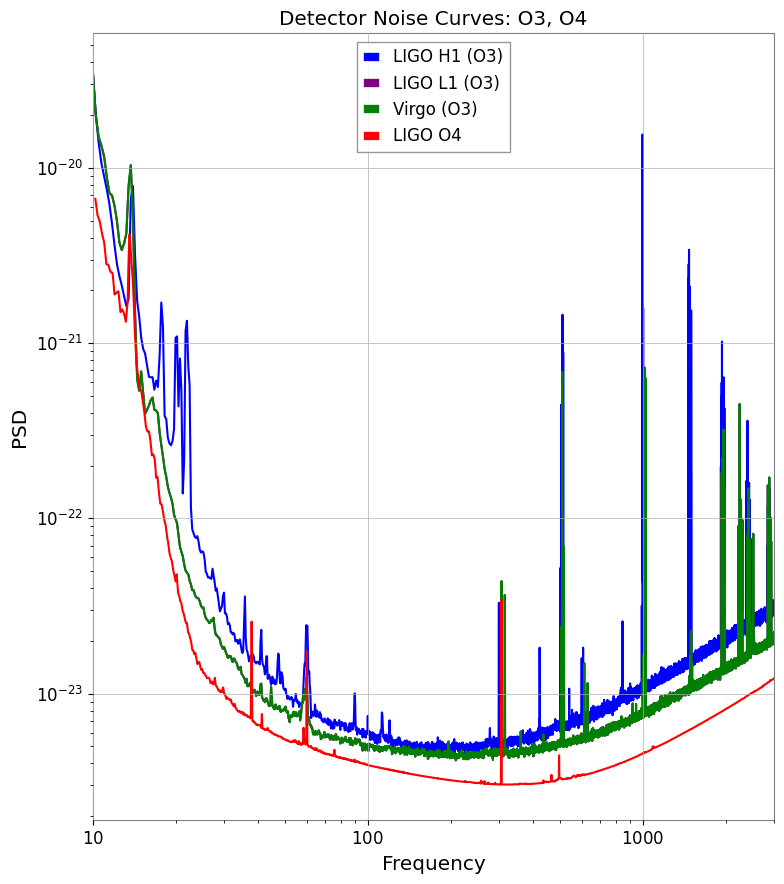

In [87]:
# PSD plots LIGO (no ET and CE data)

# Local Files
H1 = "/content/txt_files/aligo_O3actual_H1.txt"
L1 = "/content/txt_files/aligo_O3actual_L1.txt"
V1 = "/content/txt_files/aligo_O3actual_L1.txt"
O4 = "/content/txt_files/aligo_O4high (1).txt"

# PSD data from text files
f_H1, psd_H1 = np.loadtxt(H1, unpack=True)
f_L1, psd_L1 = np.loadtxt(L1, unpack=True)
f_V1, psd_V1 = np.loadtxt(V1, unpack=True)
f_O4, psd_O4 = np.loadtxt(O4, unpack=True)

plt.figure(figsize=(8, 9))

#plots all graph
plt.loglog(f_H1, psd_H1, label="LIGO H1 (O3)", color="blue")
plt.loglog(f_L1, psd_L1, label="LIGO L1 (O3)", color="purple")
plt.loglog(f_V1, psd_V1, label="Virgo (O3)", color="green")
plt.loglog(f_O4, psd_O4, label="LIGO O4 ", color="red")

plt.xlim([10, 3000]) #10Hz to 3000Hz
plt.xlabel("Frequency")
plt.ylabel(r"PSD")
plt.title("Detector Noise Curves: O3, O4")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Good job! This is the end of the second part. Maybe you can go for a break?